# Housing Prices Prediction 
In this notebook, I intend to use the <a href="https://www.kaggle.com/competitions/home-data-for-ml-course/overview">Housing Prices Competiton</a> from Kaggle to apply data processing, exploratory data analysis, and finally use regression to predict sales prices for houses. 

In [1]:
import pandas as pd
import numpy as np

# Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Outlier Removal 
from sklearn.ensemble import IsolationForest

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Initial Data Cleaning and Preprocessing

In [3]:
# MSSubClass should be a categorical variable
train_df["MSSubClass"] = train_df["MSSubClass"].astype("object")

### Missing Values

Identify the features that have a large amount of null values

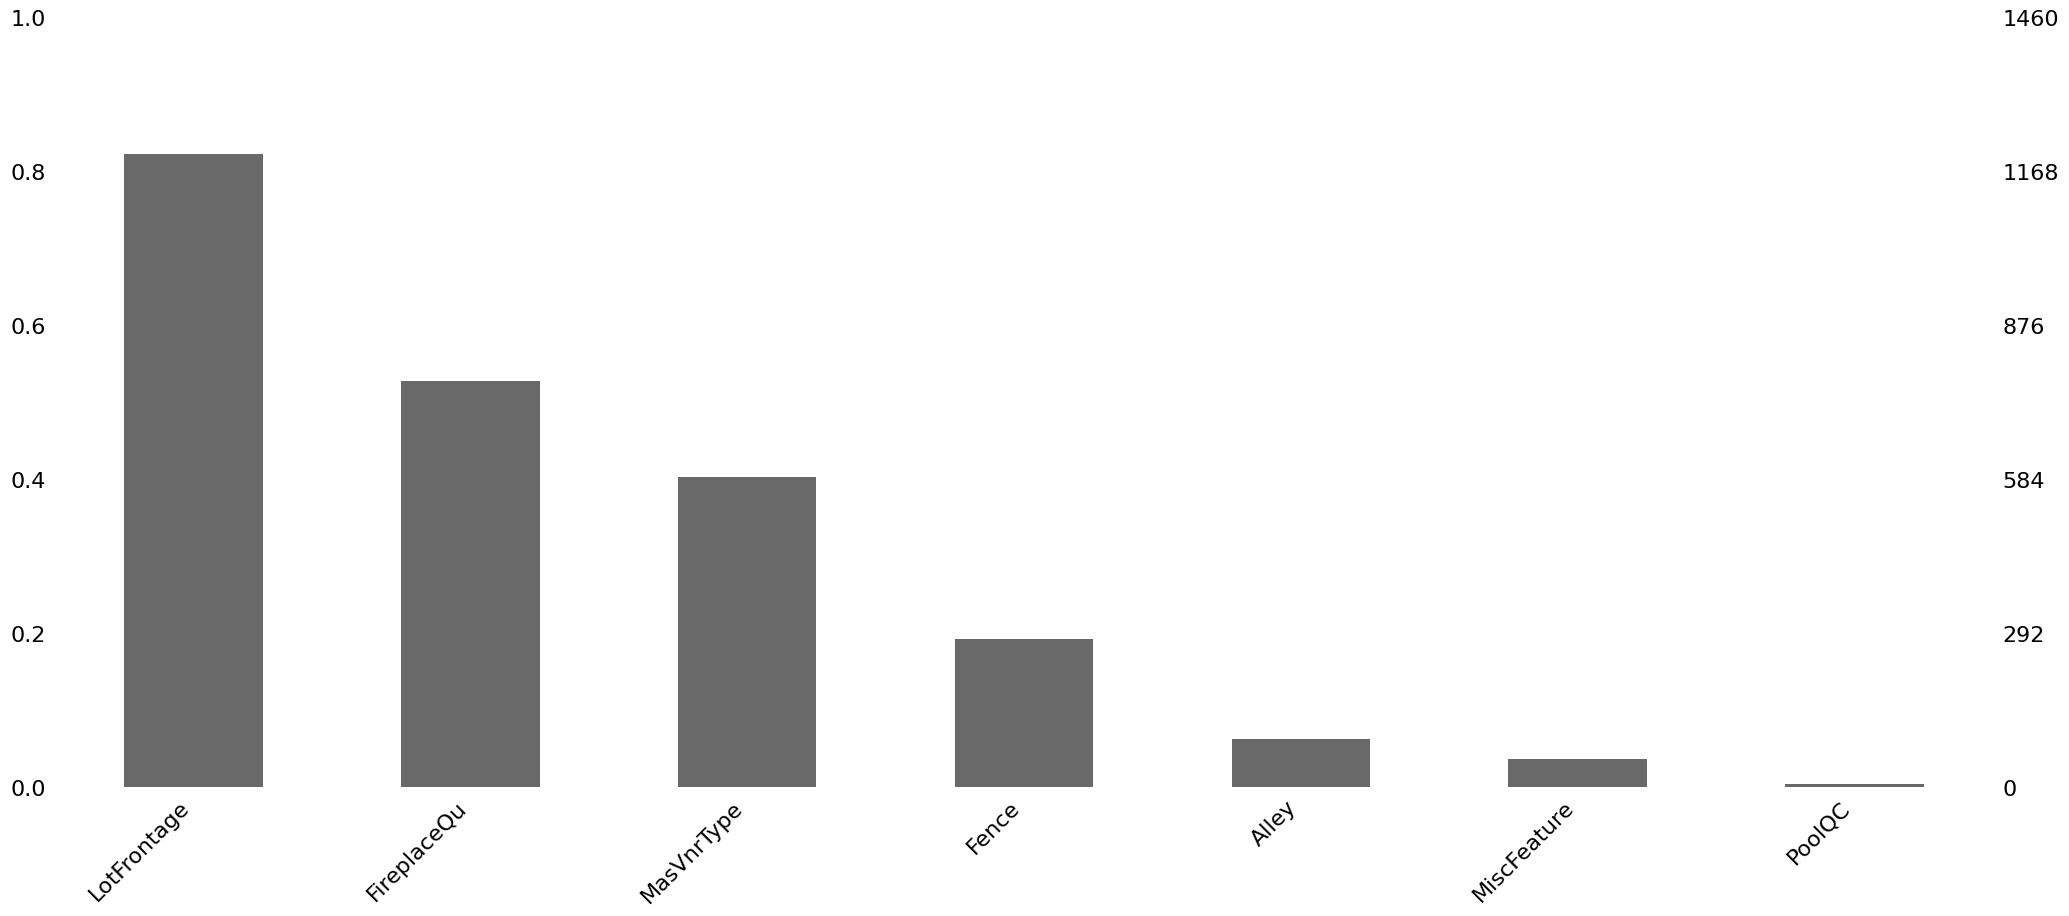

In [4]:
msno.bar(train_df, sort="descending", filter='bottom', p=0.9, fontsize=16,)
plt.xticks([])
plt.show()

In [5]:
# Directly drop the variables with high null count
# Drop PoolArea together with PoolQC, we only have 8 houses with pools (Too few instances, and they do not significantly impact price)

train_df = train_df.drop(columns=["PoolQC", "PoolArea", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu"])
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,12,2008,WD,Normal,250000


In [6]:
# Identify remaining null values
missing = train_df.isna().sum()[train_df.isna().sum().values > 0].sort_values(ascending=False)
print(missing)

missing_numerical = train_df[missing.index].select_dtypes(exclude='object')
print(missing_numerical)

LotFrontage     259
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageType       81
GarageCond       81
BsmtFinType2     38
BsmtExposure     38
BsmtQual         37
BsmtFinType1     37
BsmtCond         37
MasVnrArea        8
Electrical        1
dtype: int64
      LotFrontage  GarageYrBlt  MasVnrArea
0            65.0       2003.0       196.0
1            80.0       1976.0         0.0
2            68.0       2001.0       162.0
3            60.0       1998.0         0.0
4            84.0       2000.0       350.0
...           ...          ...         ...
1455         62.0       1999.0         0.0
1456         85.0       1978.0       119.0
1457         66.0       1941.0         0.0
1458         68.0       1950.0         0.0
1459         75.0       1965.0         0.0

[1460 rows x 3 columns]


Only three numerical variables (LotFrontage, MasVnrArea, GarageYrBlt) have missing values. Replace LotFrontage and MasVnrArea with 0, indicating that these houses have no Lot/Masonry Veneer. </br>
For the GarageYrBlt, we can observe that it has the same number of missing values as GarageFinish and other Garage-related features. This indicates that these houses have no garages, and we can leave GarageYrBlt as 0.
Similarly, there is a same number of missing values for Basement-related features, indicating that these houses have no basement. 

The missing Electrical value is likely an outlier 

In [7]:
# Replace NA values for categorical variables
basement = ["BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtFinType1", "BsmtCond"]
train_df[basement] = train_df[basement].fillna("No Basement") 

garage = ["GarageFinish", "GarageQual", "GarageCond", "GarageType"]
train_df[garage] = train_df[garage].fillna("No Garage")

# Replace NaN values for numerical variables 
numerical = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
train_df[numerical] = train_df[numerical].fillna(0)

# Remove row with missing electrical value
train_df = train_df[~train_df["Electrical"].isna()]

# Check for remaining
missing = train_df.isna().sum()[train_df.isna().sum().values > 0].sort_values(ascending=False)
print(missing)


Series([], dtype: int64)


### Duplicate Values

No duplicated values

In [8]:
duplicates = train_df.duplicated()
duplicate_rows = train_df[duplicates]

duplicate_rows.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


## Feature Engineering and Selection

Combine *numerical* features that are similar 

In [9]:
# Combine Porch Area
train_df["TotalPorch"] = train_df["OpenPorchSF"] + train_df["EnclosedPorch"] + train_df["3SsnPorch"] + train_df["ScreenPorch"]
train_df = train_df.drop(columns=["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"])

# Baths 
train_df["FullBath"] = train_df["BsmtFullBath"] + train_df["FullBath"]
train_df["HalfBath"] = train_df["HalfBath"] + train_df["BsmtHalfBath"]
train_df = train_df.drop(columns=["BsmtHalfBath", "BsmtFullBath"])

# Basement Finished 1 and 2, can drop, equal to TotalBsmtSF
train_df = train_df.drop(columns=["BsmtFinSF1", "BsmtFinSF2"])

### Numerical Variables

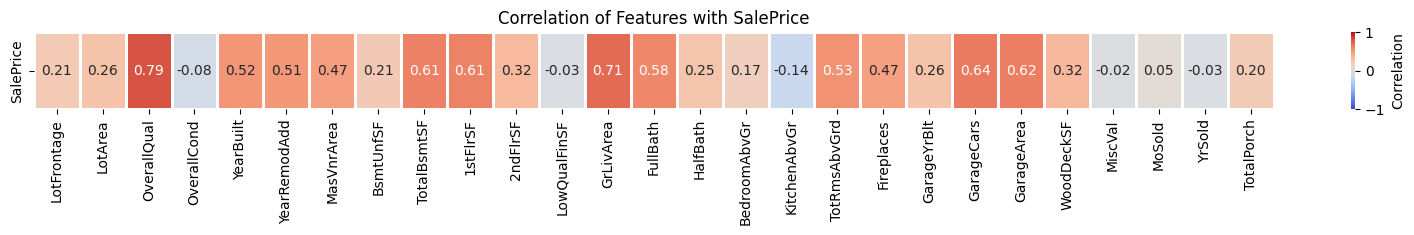

In [10]:
# Get a heatmap of all variables against salesprice
correlation_with_saleprice = train_df.drop(columns=["Id"]).select_dtypes(exclude='object').corr()['SalePrice']

correlation_with_saleprice = correlation_with_saleprice.drop('SalePrice')


plt.figure(figsize=(20, 1))  # Adjust the size as needed
sns.heatmap(correlation_with_saleprice.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'}, fmt=".2f", linewidths=1)


plt.title('Correlation of Features with SalePrice')
plt.show()

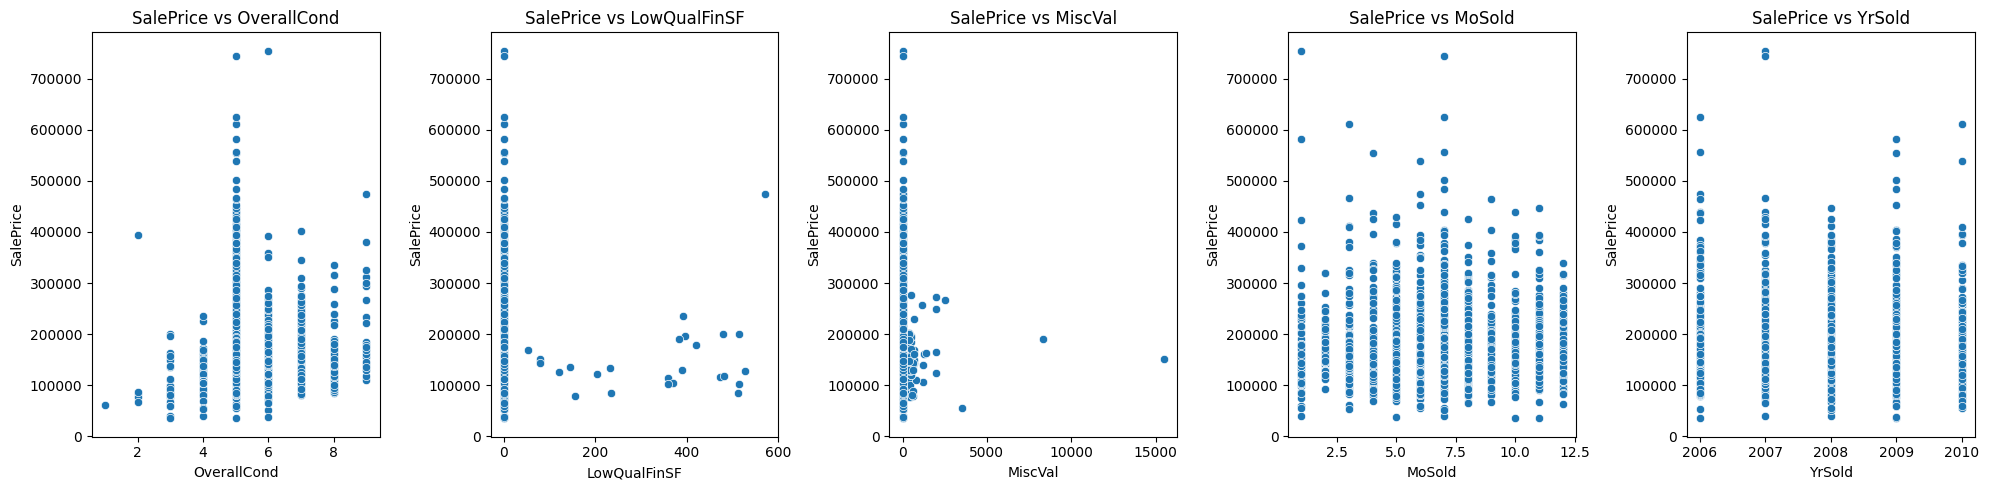

In [11]:
# Further analysis on low correlation features
plt.figure(figsize=(20, 5))

low_corr = ["OverallCond", "LowQualFinSF", "MiscVal", "MoSold", "YrSold"]

for index, col in enumerate(low_corr):
    plt.subplot(1, 5, index + 1)
    sns.scatterplot(x = train_df[col], y = train_df["SalePrice"])
    plt.title(f"SalePrice vs {col}")

plt.tight_layout()
plt.show()

In [12]:
# Drop variables that do not have strong correlation to SalePrice
train_df = train_df.drop(columns=["OverallCond", "LowQualFinSF", "MiscVal", "MoSold", "YrSold"])

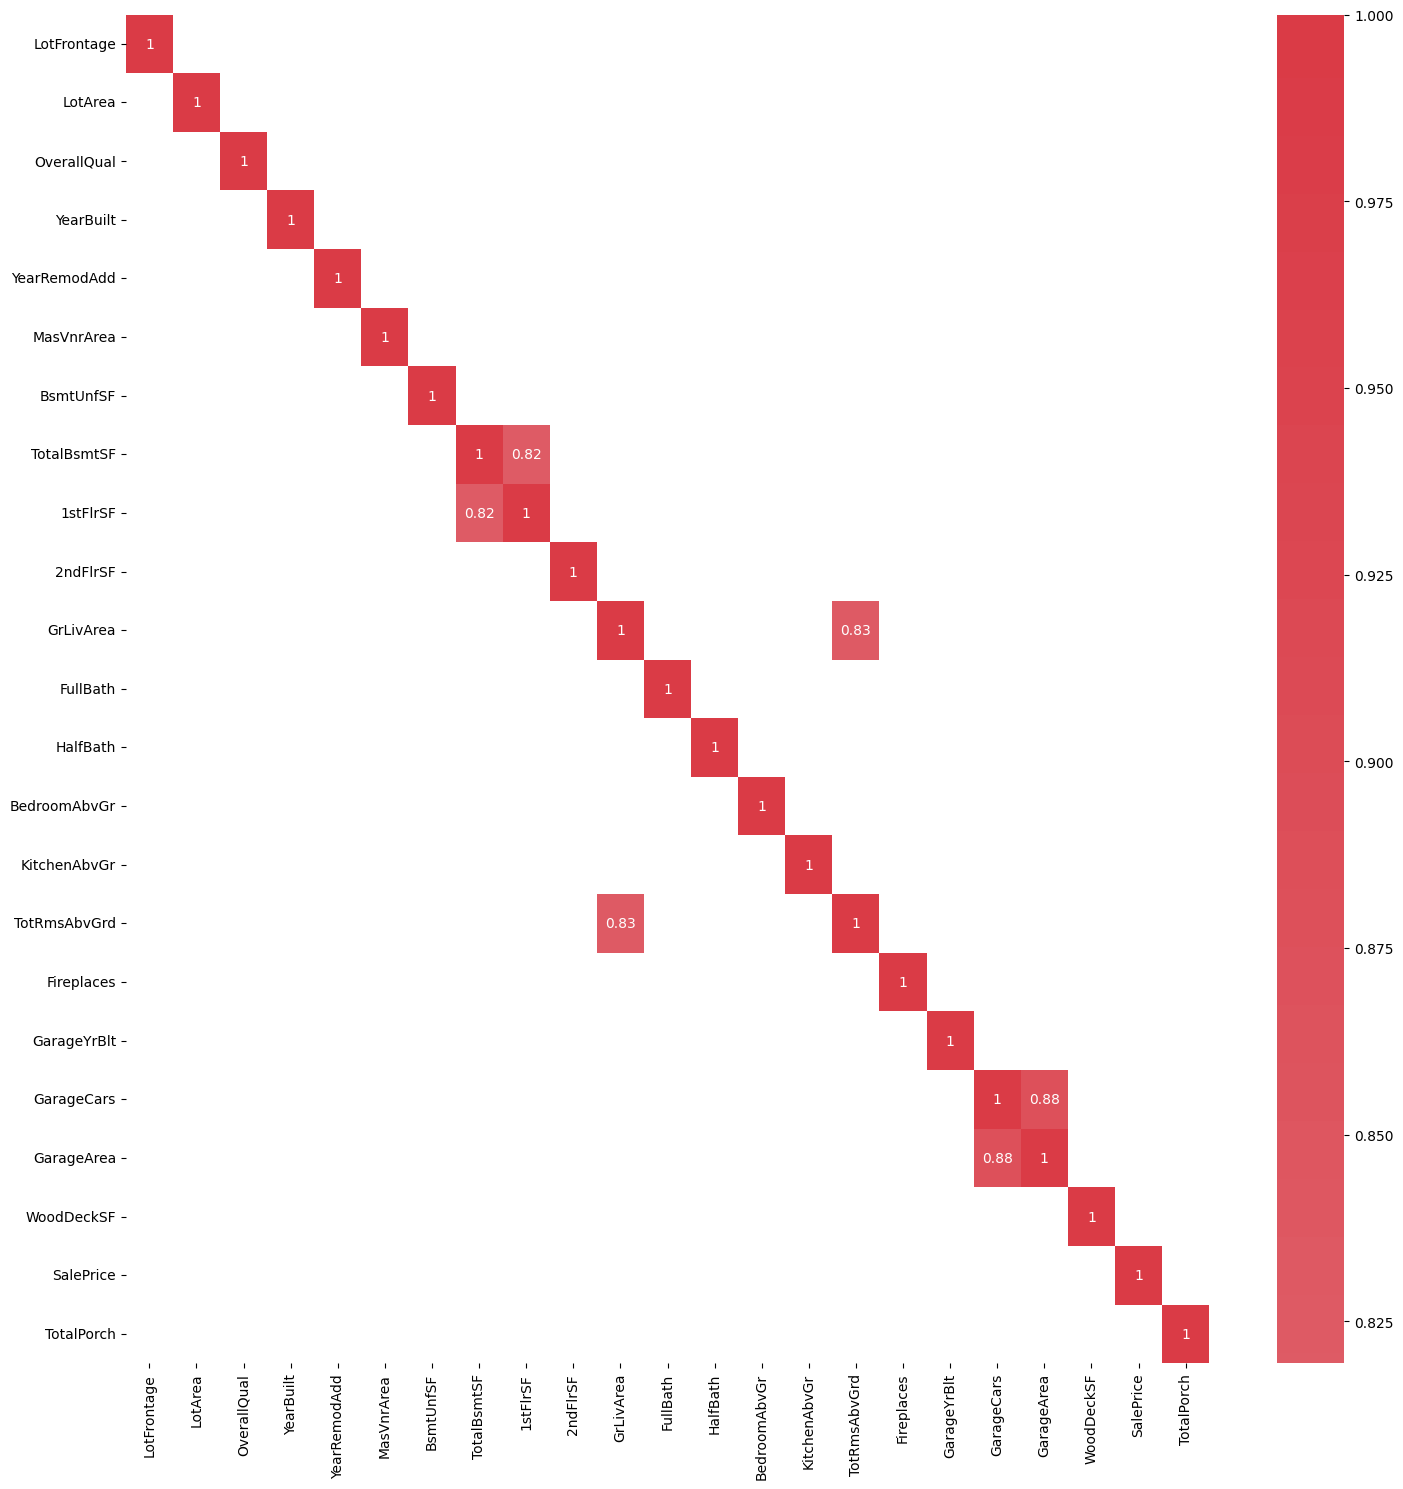

In [13]:
plt.figure(figsize=(15,15))
numerical_features = train_df.select_dtypes(exclude=["object"])
numerical_features = numerical_features.drop(columns=["Id"])

threshold = 0.8
mask = (numerical_features.corr().abs() < threshold) & (numerical_features.corr() != 1)
sns.heatmap(numerical_features.corr(), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0.0, mask=mask)

plt.tight_layout()
plt.show()

In [14]:
# Identify variables with high correlation
correlation_matrix = train_df.select_dtypes(exclude='object').corr()

threshold = 0.8

correlation_pairs = correlation_matrix.unstack()
print(correlation_pairs[(correlation_pairs > threshold) & (correlation_pairs < 1)])

TotalBsmtSF   1stFlrSF        0.819393
1stFlrSF      TotalBsmtSF     0.819393
GrLivArea     TotRmsAbvGrd    0.825576
TotRmsAbvGrd  GrLivArea       0.825576
GarageCars    GarageArea      0.882613
GarageArea    GarageCars      0.882613
dtype: float64


In [15]:
# Remove GarageCars and TotRmsAbvGrd
train_df = train_df.drop(columns=["GarageCars", "TotRmsAbvGrd"])

### Outlier Removal

In [16]:
# Remove Outliers for numerical variables using Isolation Forest 
iso = IsolationForest(contamination=0.05, random_state=1)

numerical_columns = train_df.select_dtypes(exclude="object")

iso.fit(numerical_columns)

outliers = iso.predict(numerical_columns)

print(f"Number of outliers removed: {(outliers == -1).sum()}")

train_df = train_df[outliers == 1]


Number of outliers removed: 73


### Catgorical Variables

Observe the distribution of categorical variables

In [ ]:
# Identify categorical features
categorical_cols = train_df.select_dtypes(include=["object"]).columns

# Define a function to check for features with a dominant category (90% or more)
def get_highly_skewed_features(df, threshold=0.90):
    skewed_features = []
    for feature in df.columns:
        value_counts = df[feature].value_counts(normalize=True)
        max_percentage = value_counts.max()
        if max_percentage > threshold:
            skewed_features.append(feature)
    return skewed_features

skewed_features = get_highly_skewed_features(train_df[categorical_cols])

plt.figure(figsize=(20, 15))

for index, feature in enumerate(skewed_features):
    plt.subplot(len(skewed_features) // 4 + 1, 4, index + 1)
    sns.countplot(data=train_df, x=feature, order=train_df[feature].value_counts().index)
    plt.title(feature)

plt.tight_layout()
plt.show()


<Figure size 2000x1500 with 0 Axes>

In [18]:
# Remove features with at least 90% in a single category 

threshold = 0.90

categorical_cols = train_df.select_dtypes(["object"]).columns

dominant_features = []

for feature in categorical_cols:
    value_counts = train_df[feature].value_counts(normalize = True)

    if value_counts.iloc[0] > threshold:
        dominant_features.append(feature)

train_df = train_df.drop(columns = dominant_features)

## Data Summary and Visualization

In [19]:
def summarise_data(df):
    summary = {
        "Feature": [],
        "Data Type": [],
        "Min": [],
        "Max": [],
        "Mean": [],
        "Std": [],
        "Lower Quartile": [],
        "Median": [],
        "Upper Quartile": [],
        "Mode": []
    }

    summary_stats = df.describe().T

    # Data Types and Summary Statistics
    for column in df.columns: 
        if df[column].dtype in [np.int64, np.float64]:
            summary["Feature"].append(column)
            summary["Data Type"].append(df[column].dtype)
            summary["Min"].append(summary_stats.loc[column, "min"])
            summary["Max"].append(summary_stats.loc[column, "max"])
            summary["Mean"].append(summary_stats.loc[column, "mean"])
            summary["Std"].append(summary_stats.loc[column, "std"])
            summary["Lower Quartile"].append(summary_stats.loc[column, "25%"])
            summary["Median"].append(summary_stats.loc[column, "50%"])
            summary["Upper Quartile"].append(summary_stats.loc[column, "75%"])

            summary["Mode"].append(df[column].mode()[0])

    
    return pd.DataFrame(summary)

summarise_data(train_df.drop(columns=["Id"]))

,Feature,Data Type,Min,Max,Mean,Std,Lower Quartile,Median,Upper Quartile,Mode
0,LotFrontage,float64,0.0,313.0,56.414863,33.358121,40.25,62.0,78.00,0.0
1,LotArea,int64,1300.0,159000.0,10006.463925,7024.290831,7500.00,9351.5,11365.75,7200.0
2,OverallQual,int64,2.0,10.0,6.053391,1.296496,5.00,6.0,7.00,5.0
3,YearBuilt,int64,1875.0,2010.0,1971.595960,29.562828,1954.00,1972.0,2000.00,2005.0
4,YearRemodAdd,int64,1950.0,2010.0,1984.740981,20.657496,1966.00,1993.0,2004.00,1950.0
5,MasVnrArea,float64,0.0,1600.0,92.877345,158.312489,0.00,0.0,153.00,0.0
6,BsmtUnfSF,int64,0.0,2046.0,558.106782,427.074402,224.00,473.5,798.00,0.0
7,TotalBsmtSF,int64,0.0,3206.0,1034.023810,381.414957,795.25,980.5,1260.75,864.0
8,1stFlrSF,int64,438.0,2898.0,1136.504329,344.887662,874.00,1074.5,1352.00,864.0
9,2ndFlrSF,int64,0.0,1611.0,328.208514,415.578013,0.00,0.0,712.75,0.0


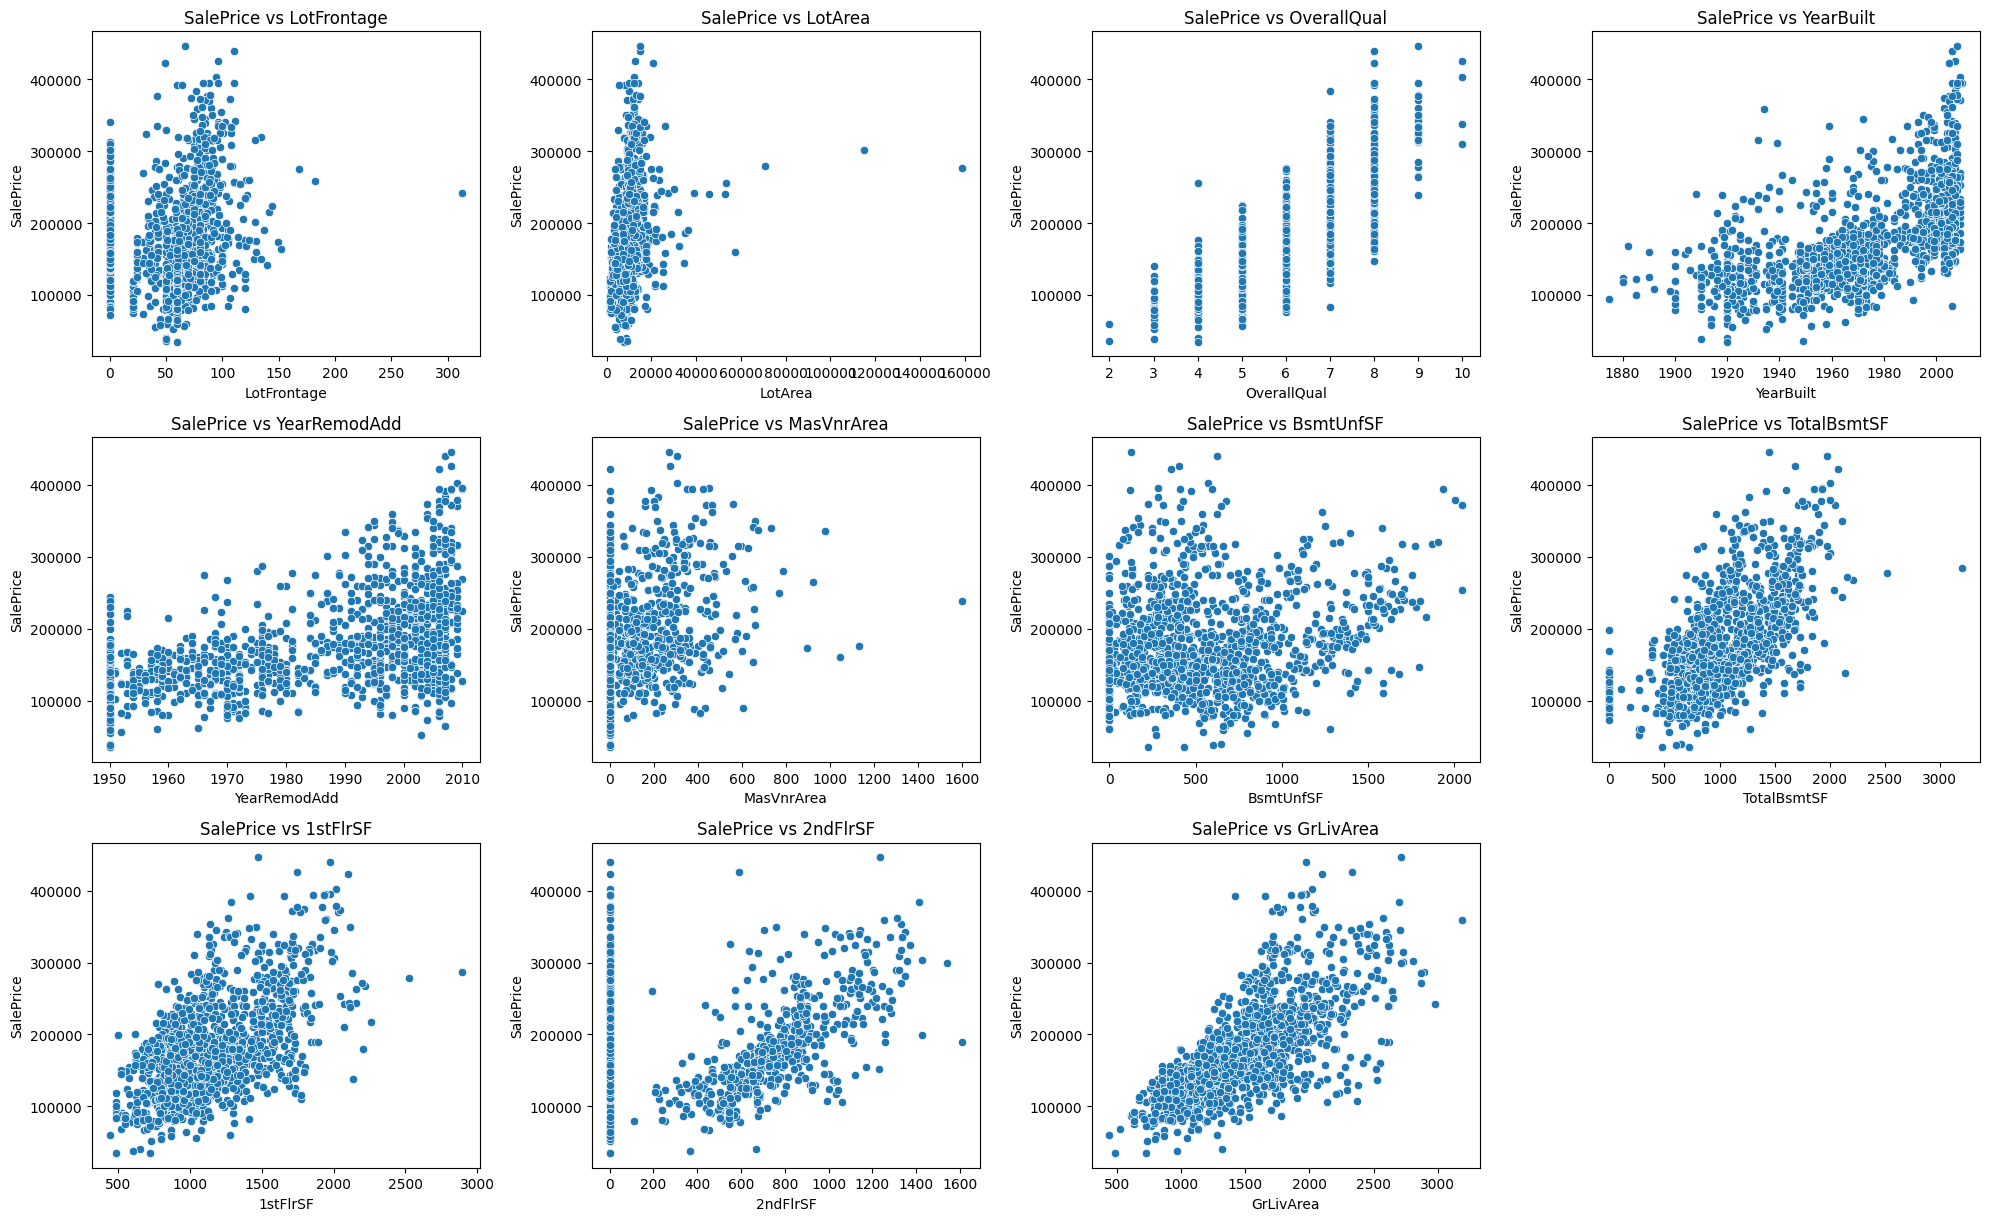

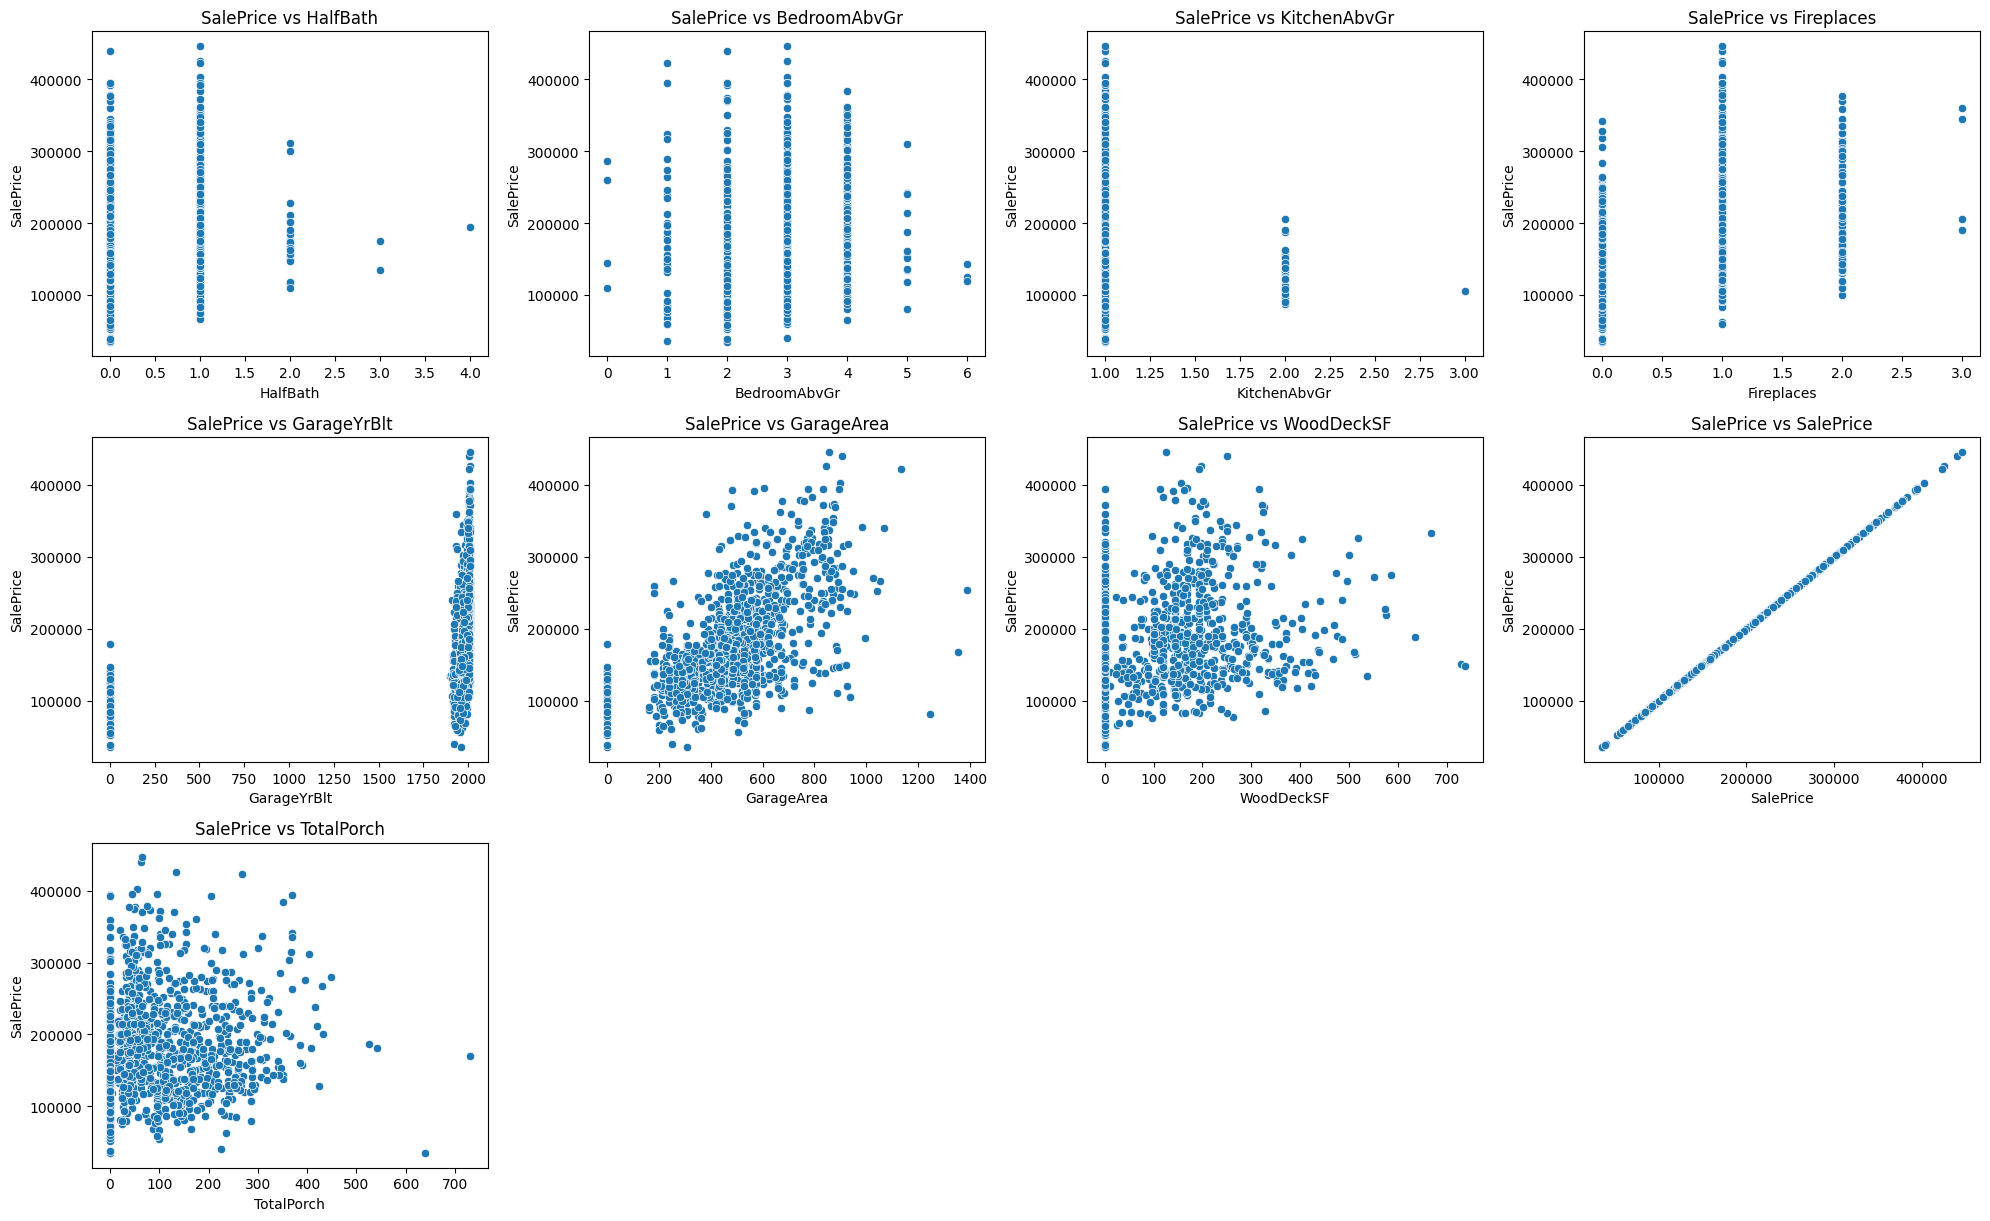

In [20]:
# Select numerical features
numerical_columns = train_df.select_dtypes(exclude=["object"]).columns
numerical_columns = numerical_columns.drop(["Id"])

# Create scatterplots for all numerical features against SalePrice
plt.figure(figsize=(20, 20))

for index, feature in enumerate(numerical_columns[:len(numerical_columns)//2 + 1]):
    plt.subplot(5, 4, index + 1)
    sns.scatterplot(x = train_df[feature], y = train_df["SalePrice"])
    plt.title(f"SalePrice vs {feature}")

plt.tight_layout()

plt.figure(figsize=(20, 20))

for index, feature in enumerate(numerical_columns[len(numerical_columns)//2 + 2:]):
    plt.subplot(5, 4, index + 1)
    sns.scatterplot(x = train_df[feature], y = train_df["SalePrice"])
    plt.title(f"SalePrice vs {feature}")

plt.tight_layout()

plt.show()

Visualise categorical variables using boxplots and histograms

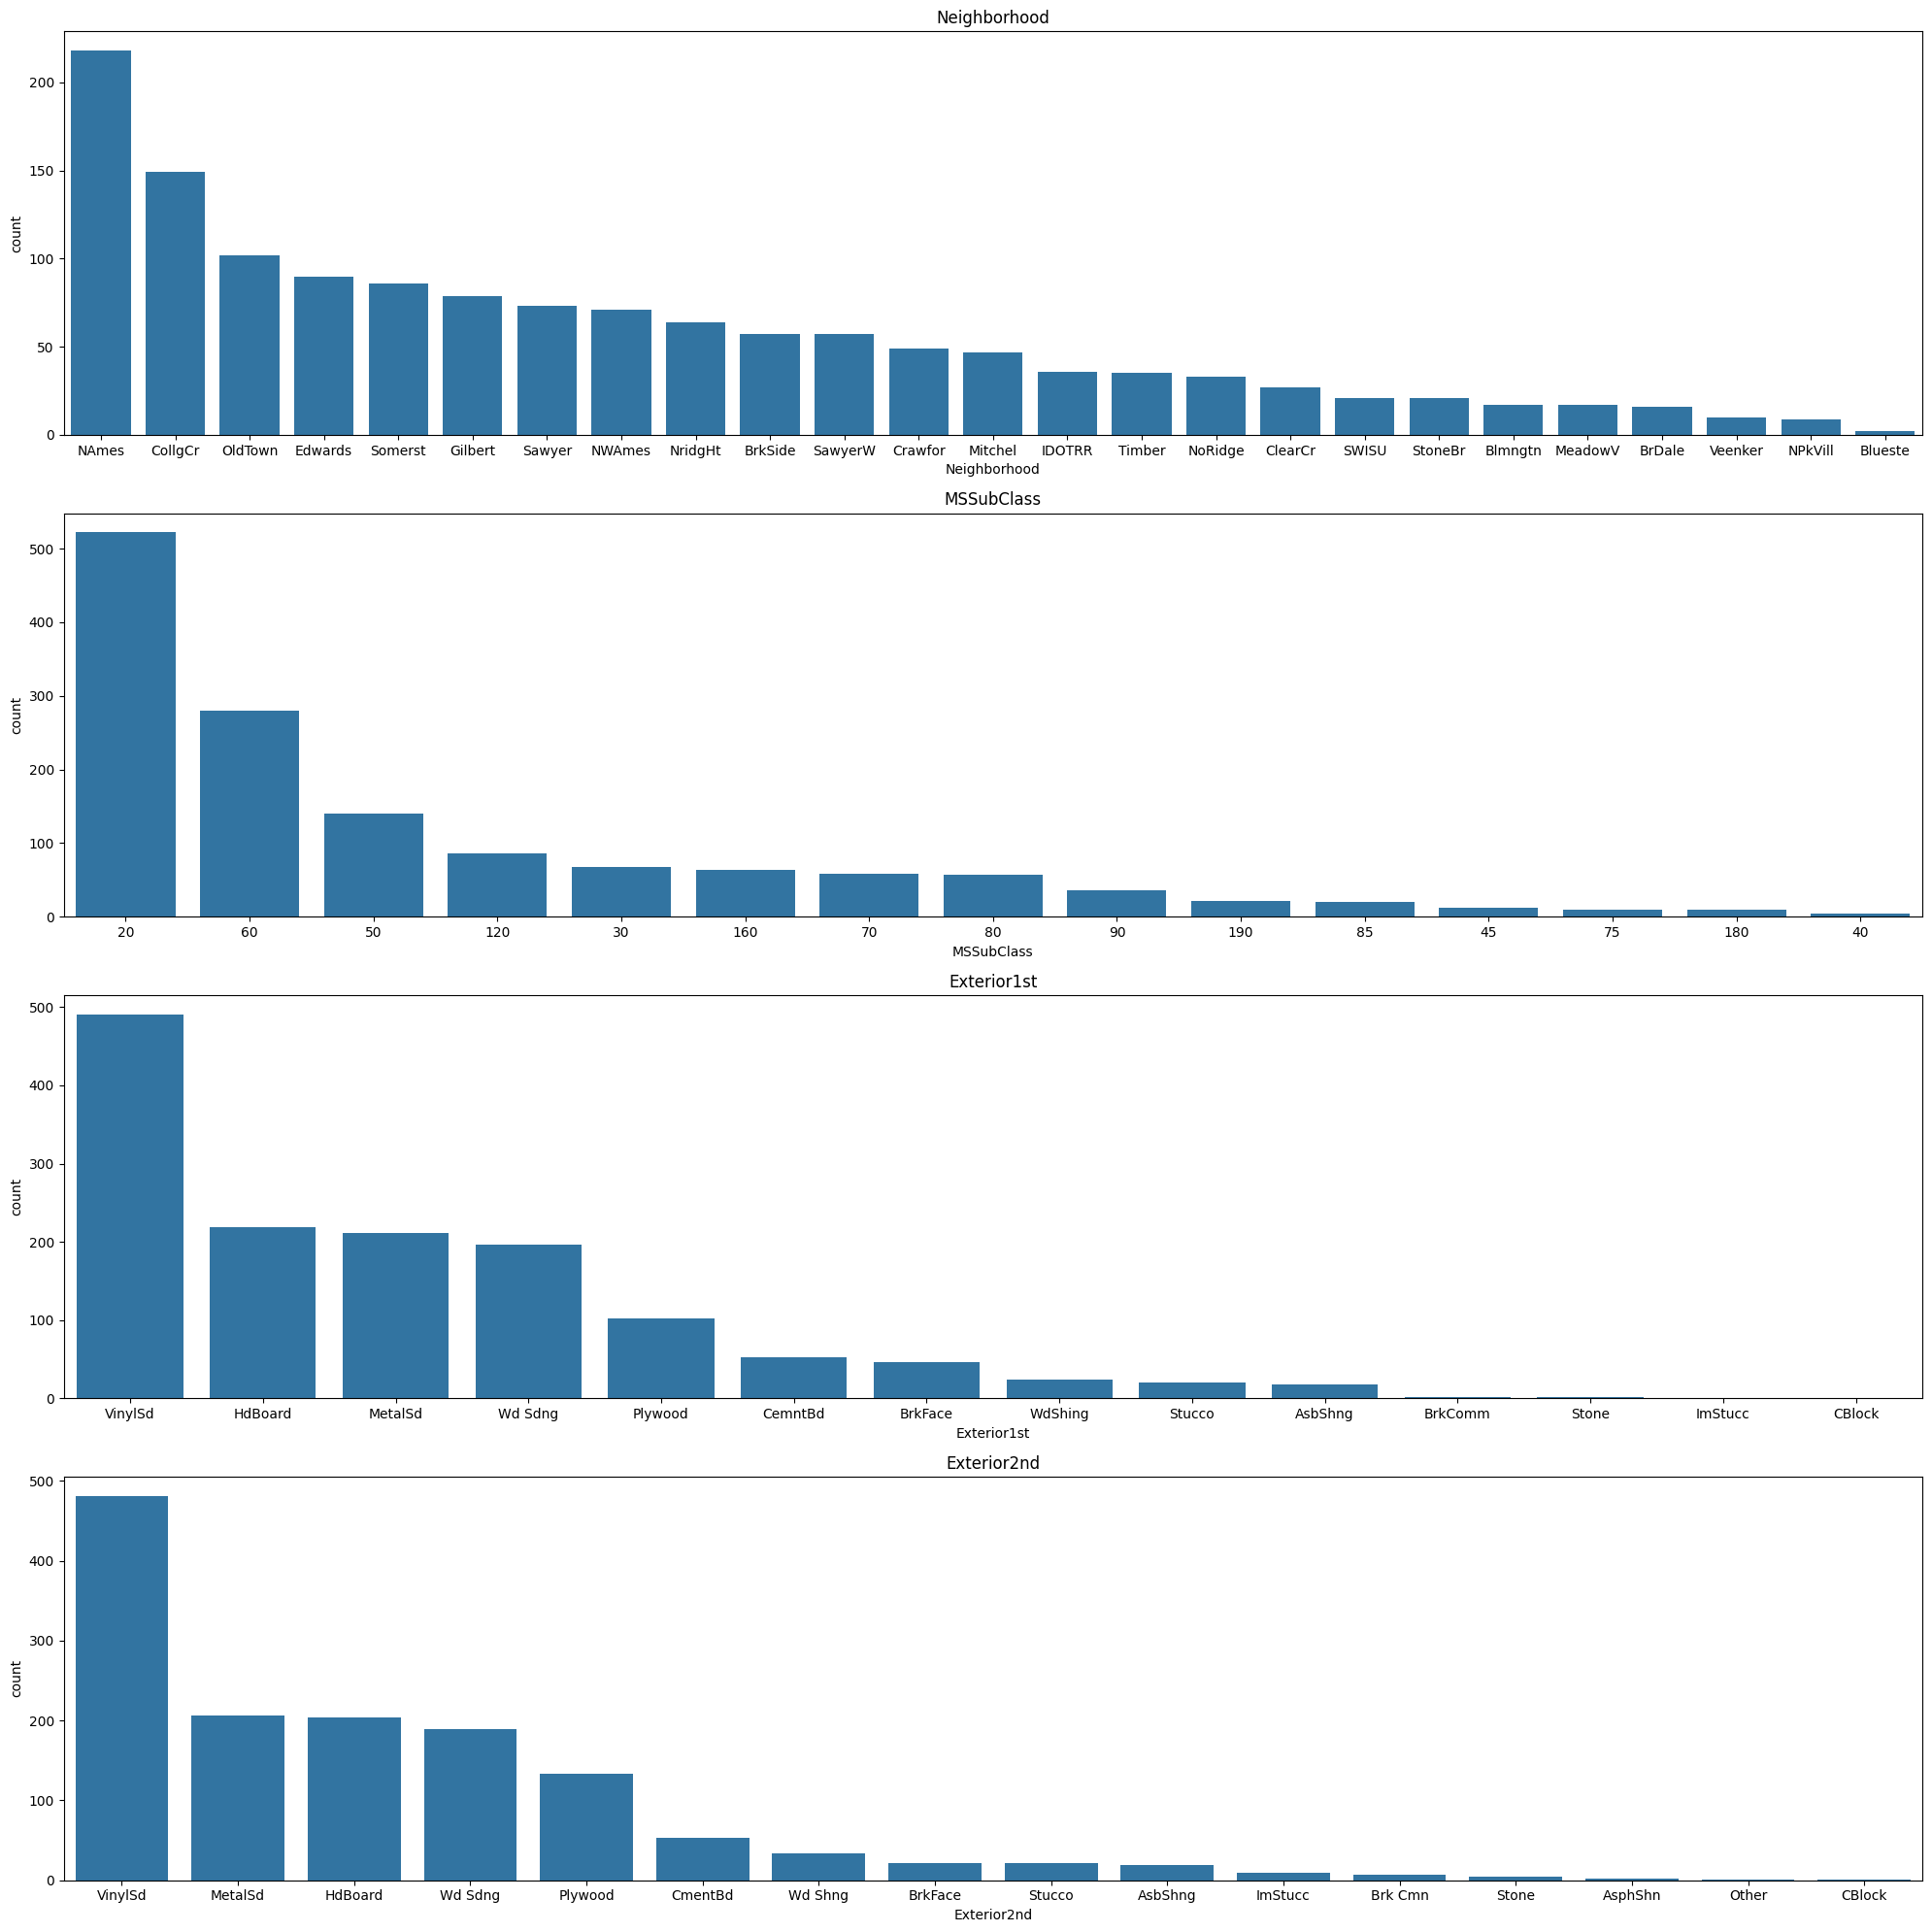

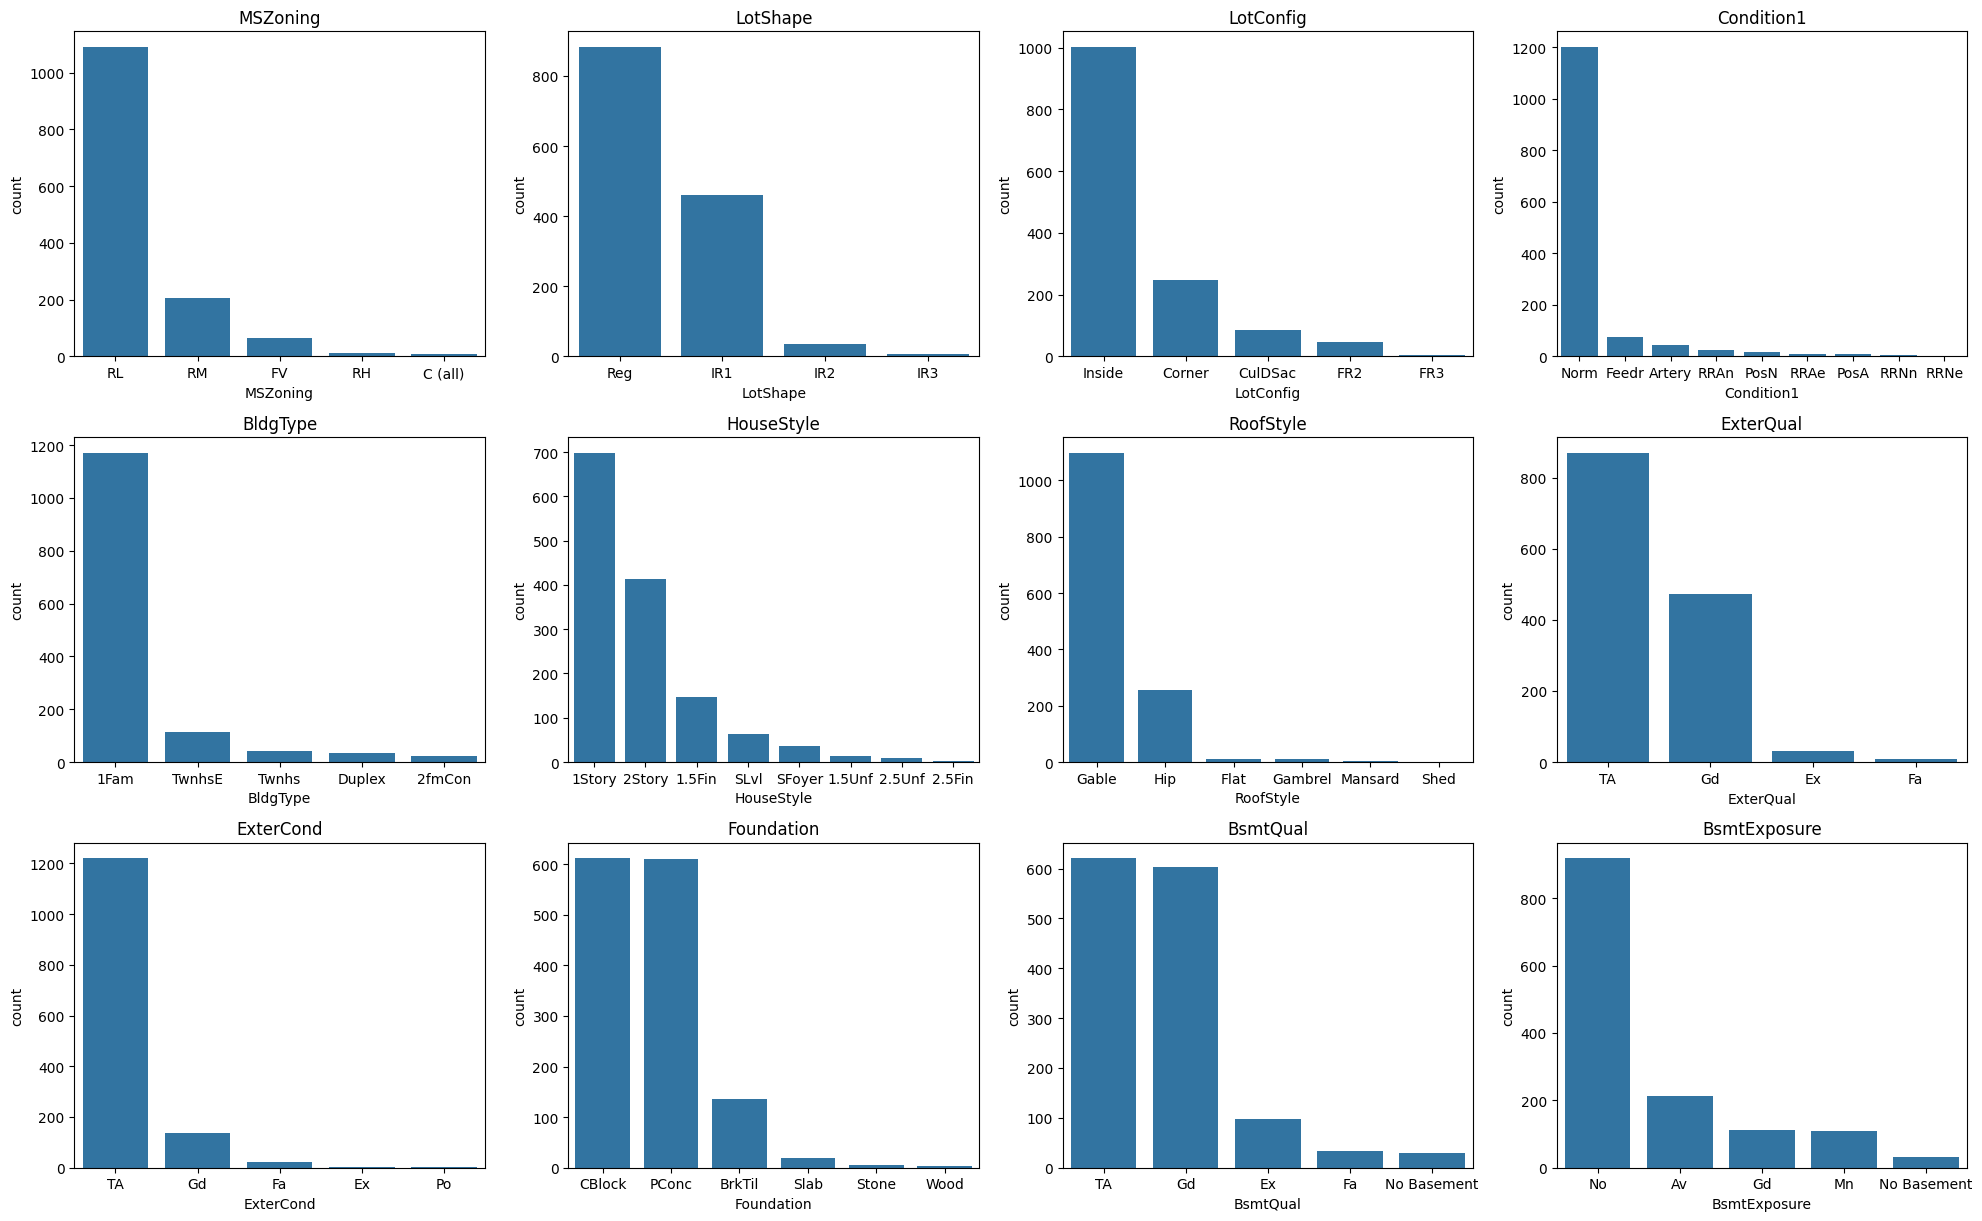

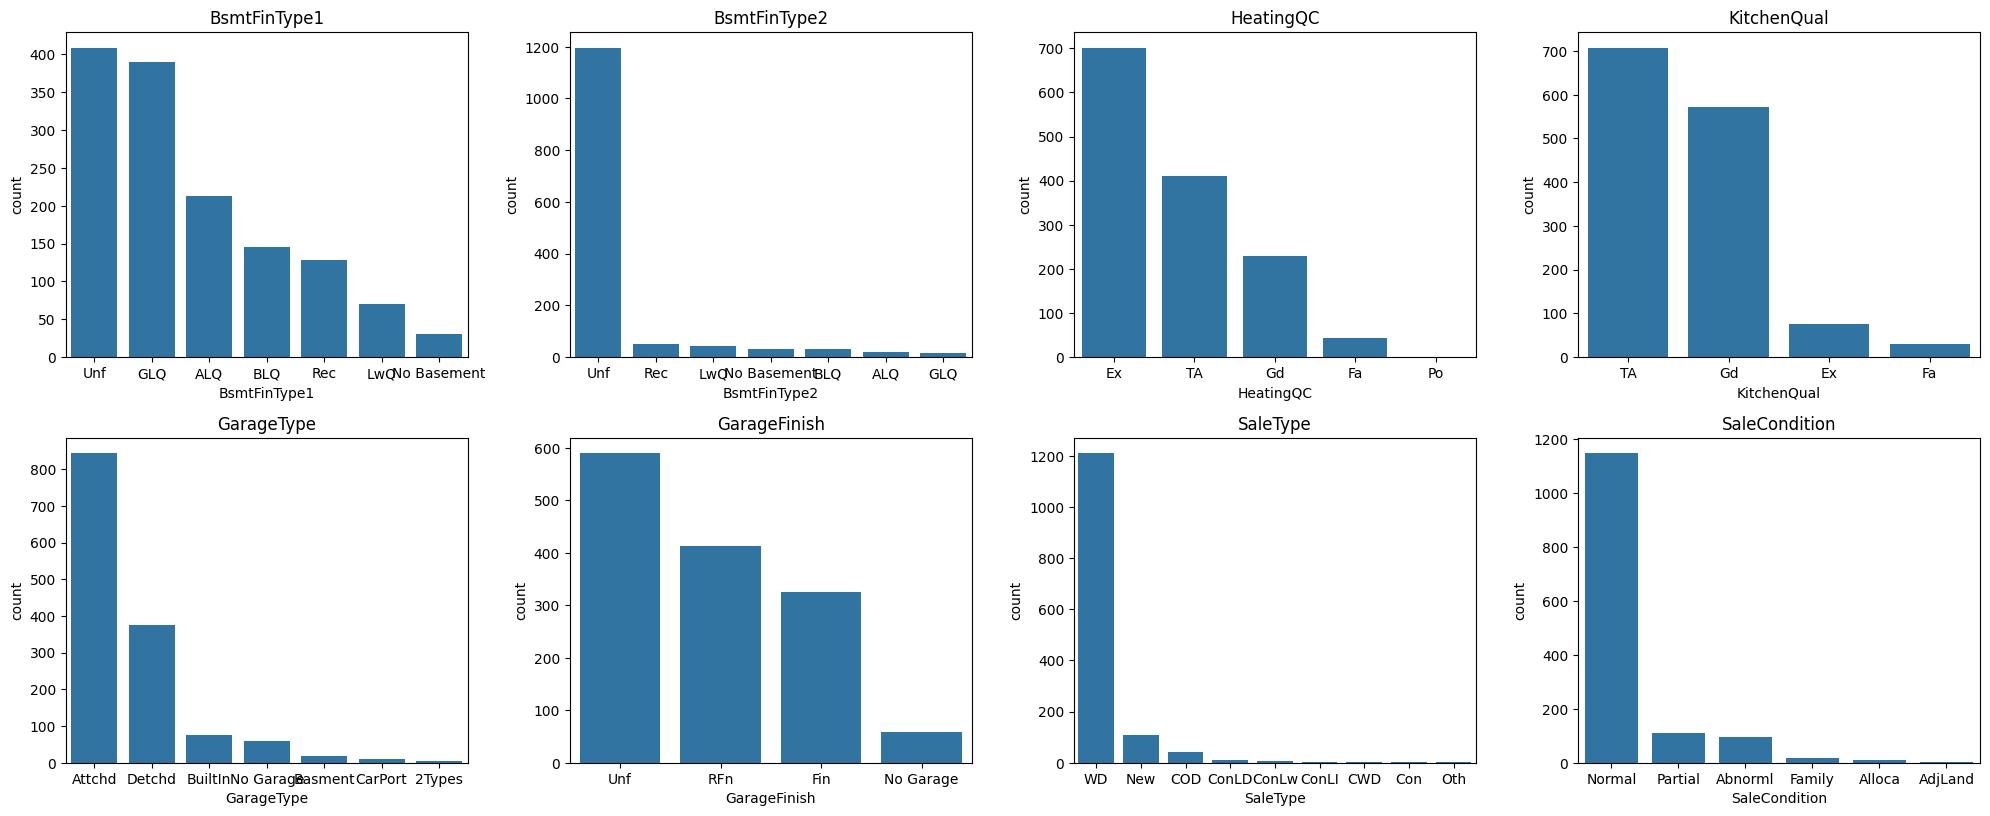

In [21]:
categorical_cols = train_df.select_dtypes(include=["object"]).columns

drop_columns = ["Neighborhood", "MSSubClass", "Exterior1st", "Exterior2nd"]

plt.figure(figsize=(20, 20))
for index, feature in enumerate(drop_columns):
    plt.subplot(4, 1, index + 1)
    sns.countplot(data = train_df, x = feature, order = train_df[feature].value_counts().index)

    plt.title(feature)

plt.tight_layout()

categorical_cols = categorical_cols.drop(drop_columns)

plt.figure(figsize=(20, 20))

for index, feature in enumerate(categorical_cols[:len(categorical_cols) // 2 + 2]):
    plt.subplot(5, 4, index + 1)
    sns.countplot(data = train_df, x = feature, order = train_df[feature].value_counts().index)

    plt.title(feature)

plt.tight_layout()

plt.figure(figsize=(20, 20))

for index, feature in enumerate(categorical_cols[len(categorical_cols) // 2 + 2:]):
    plt.subplot(5, 4, index + 1)
    sns.countplot(data = train_df, x = feature, order = train_df[feature].value_counts().index)

    plt.title(feature)

plt.tight_layout()

plt.show()

We can observe that the dataset is highly skewed, possibly because certain features are more common and practical in houses than others

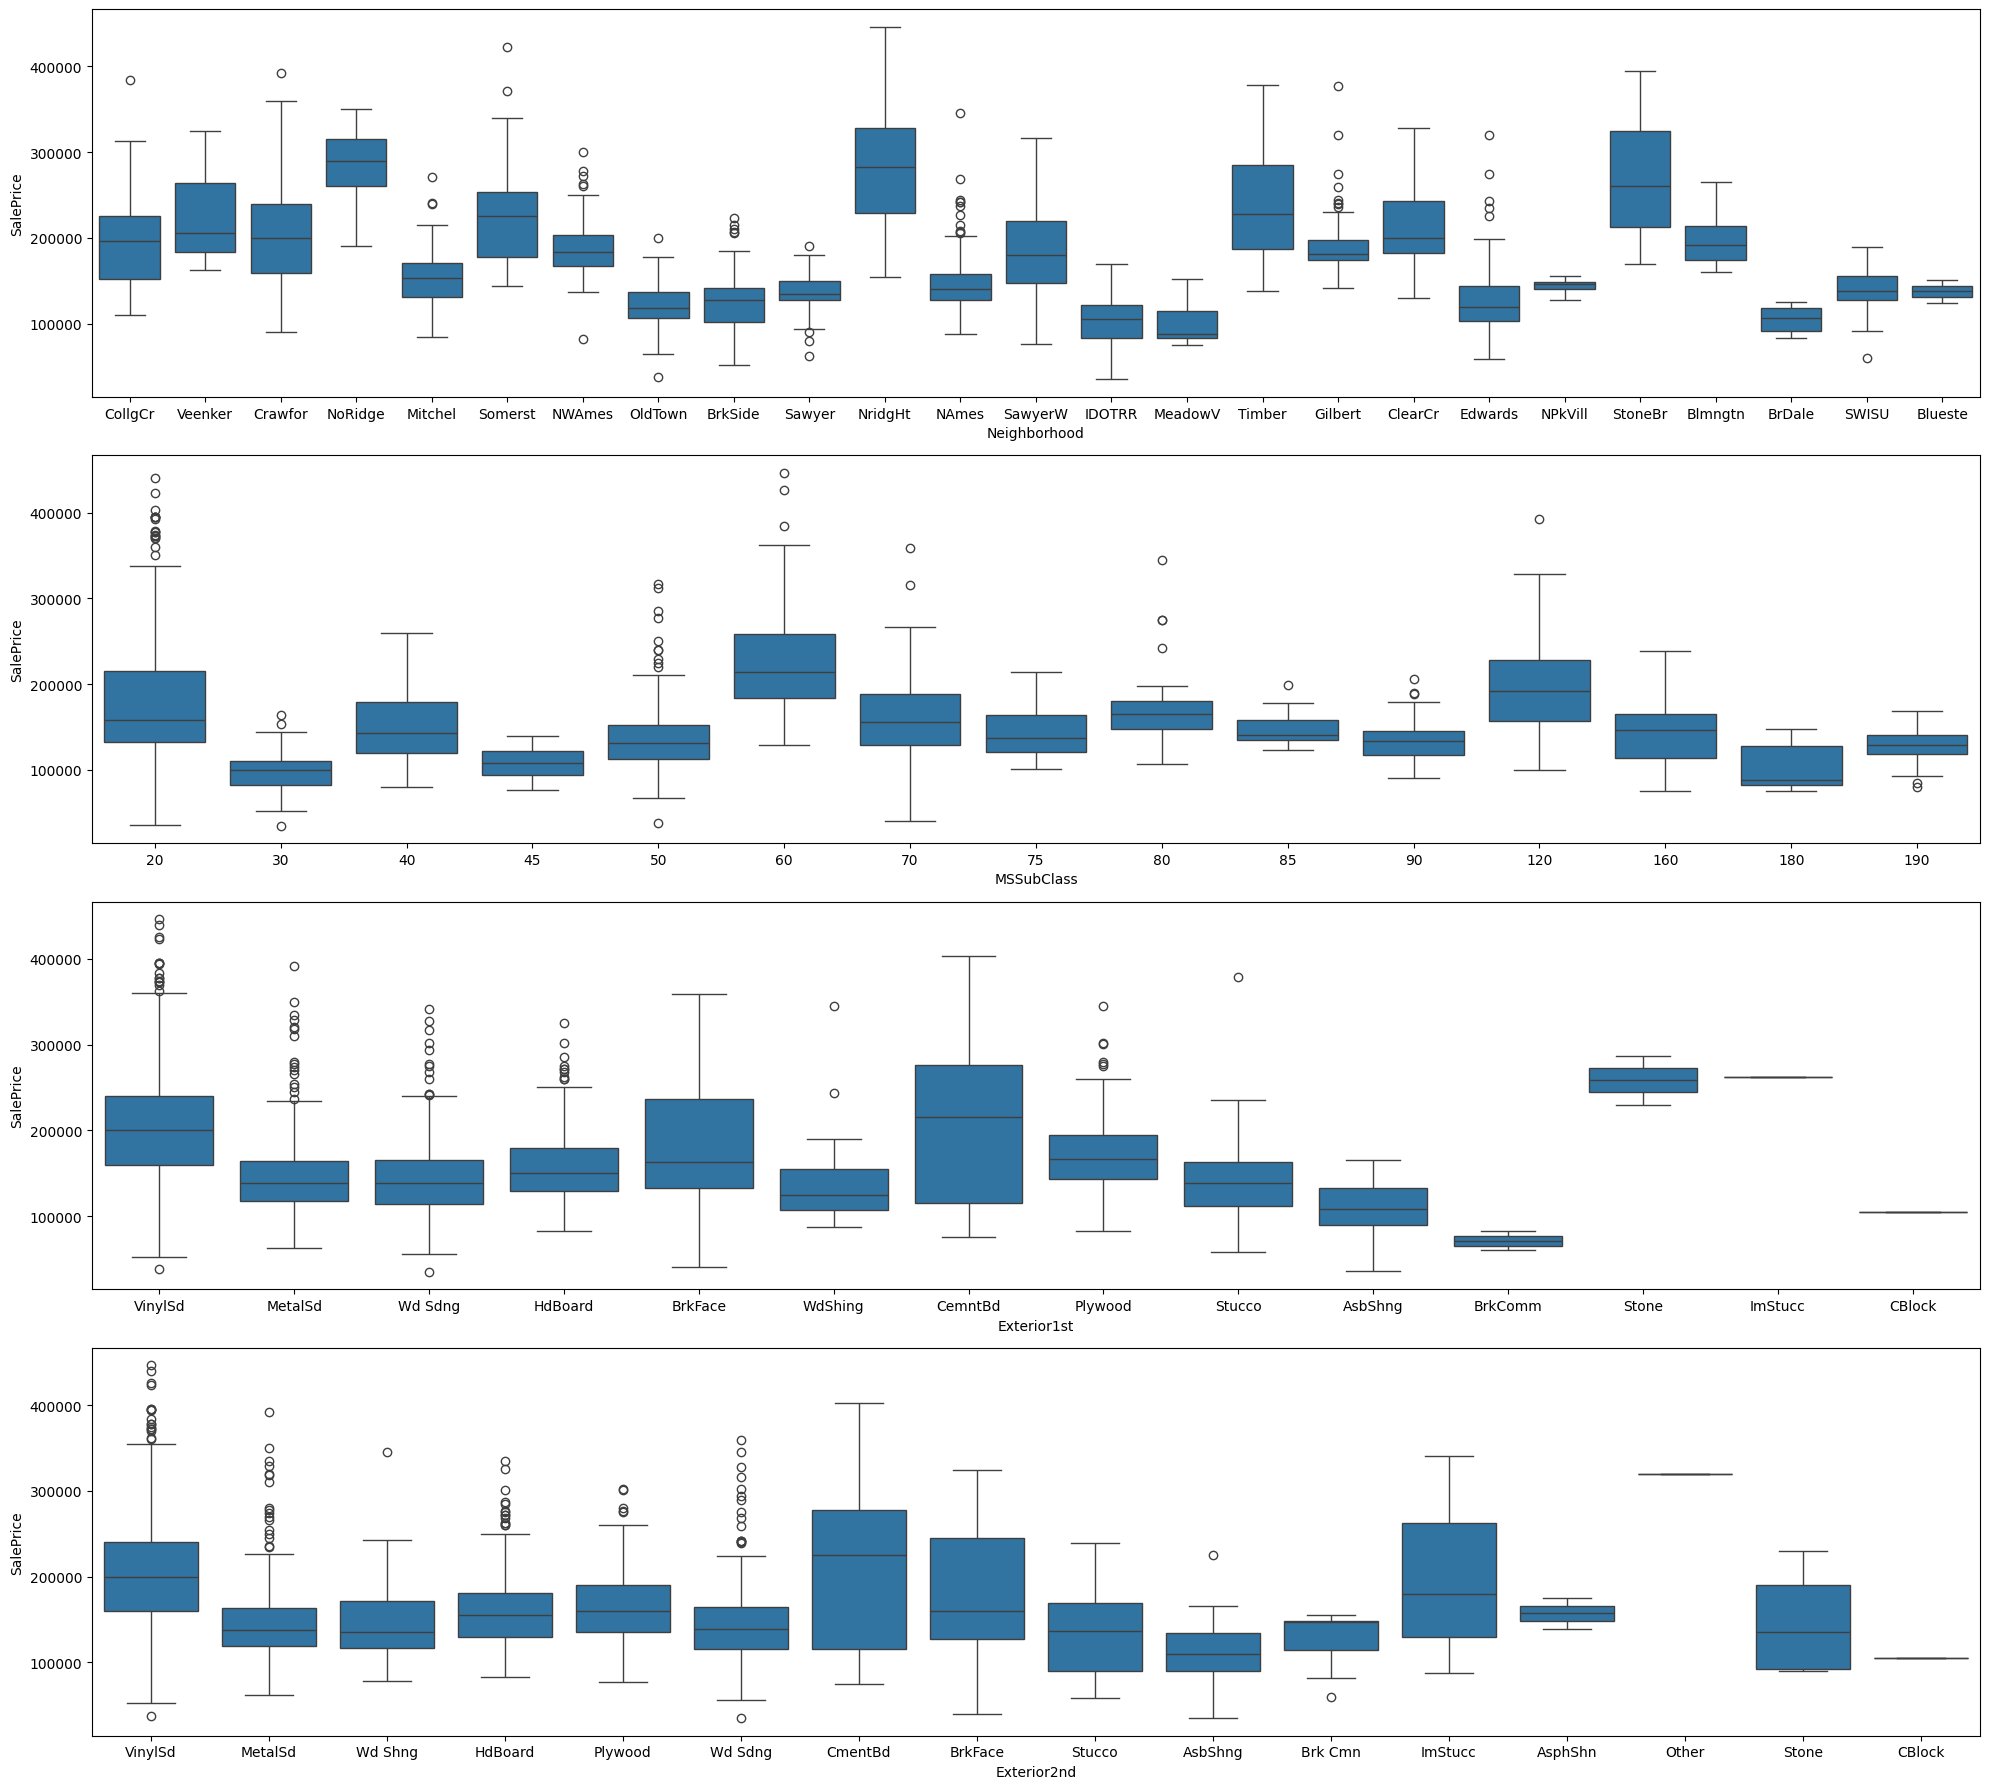

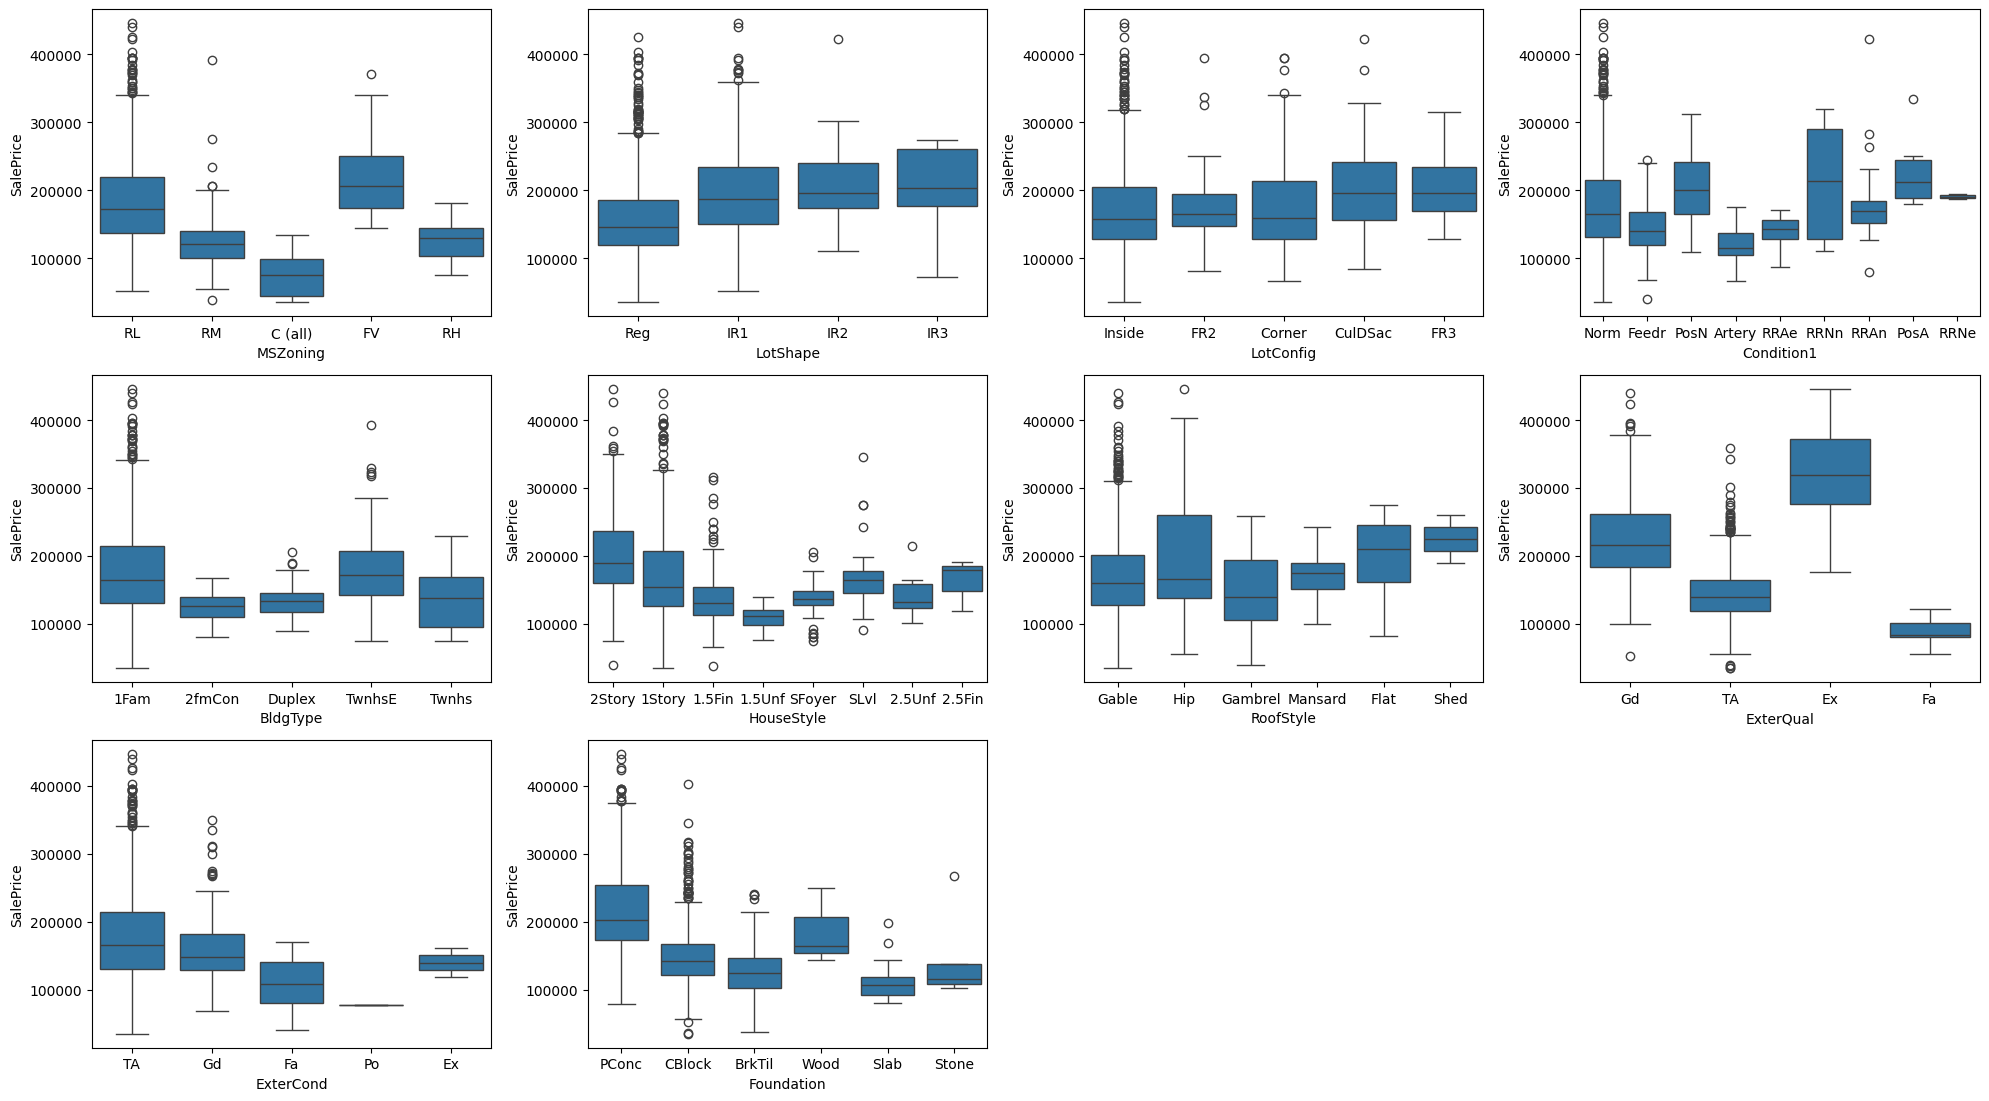

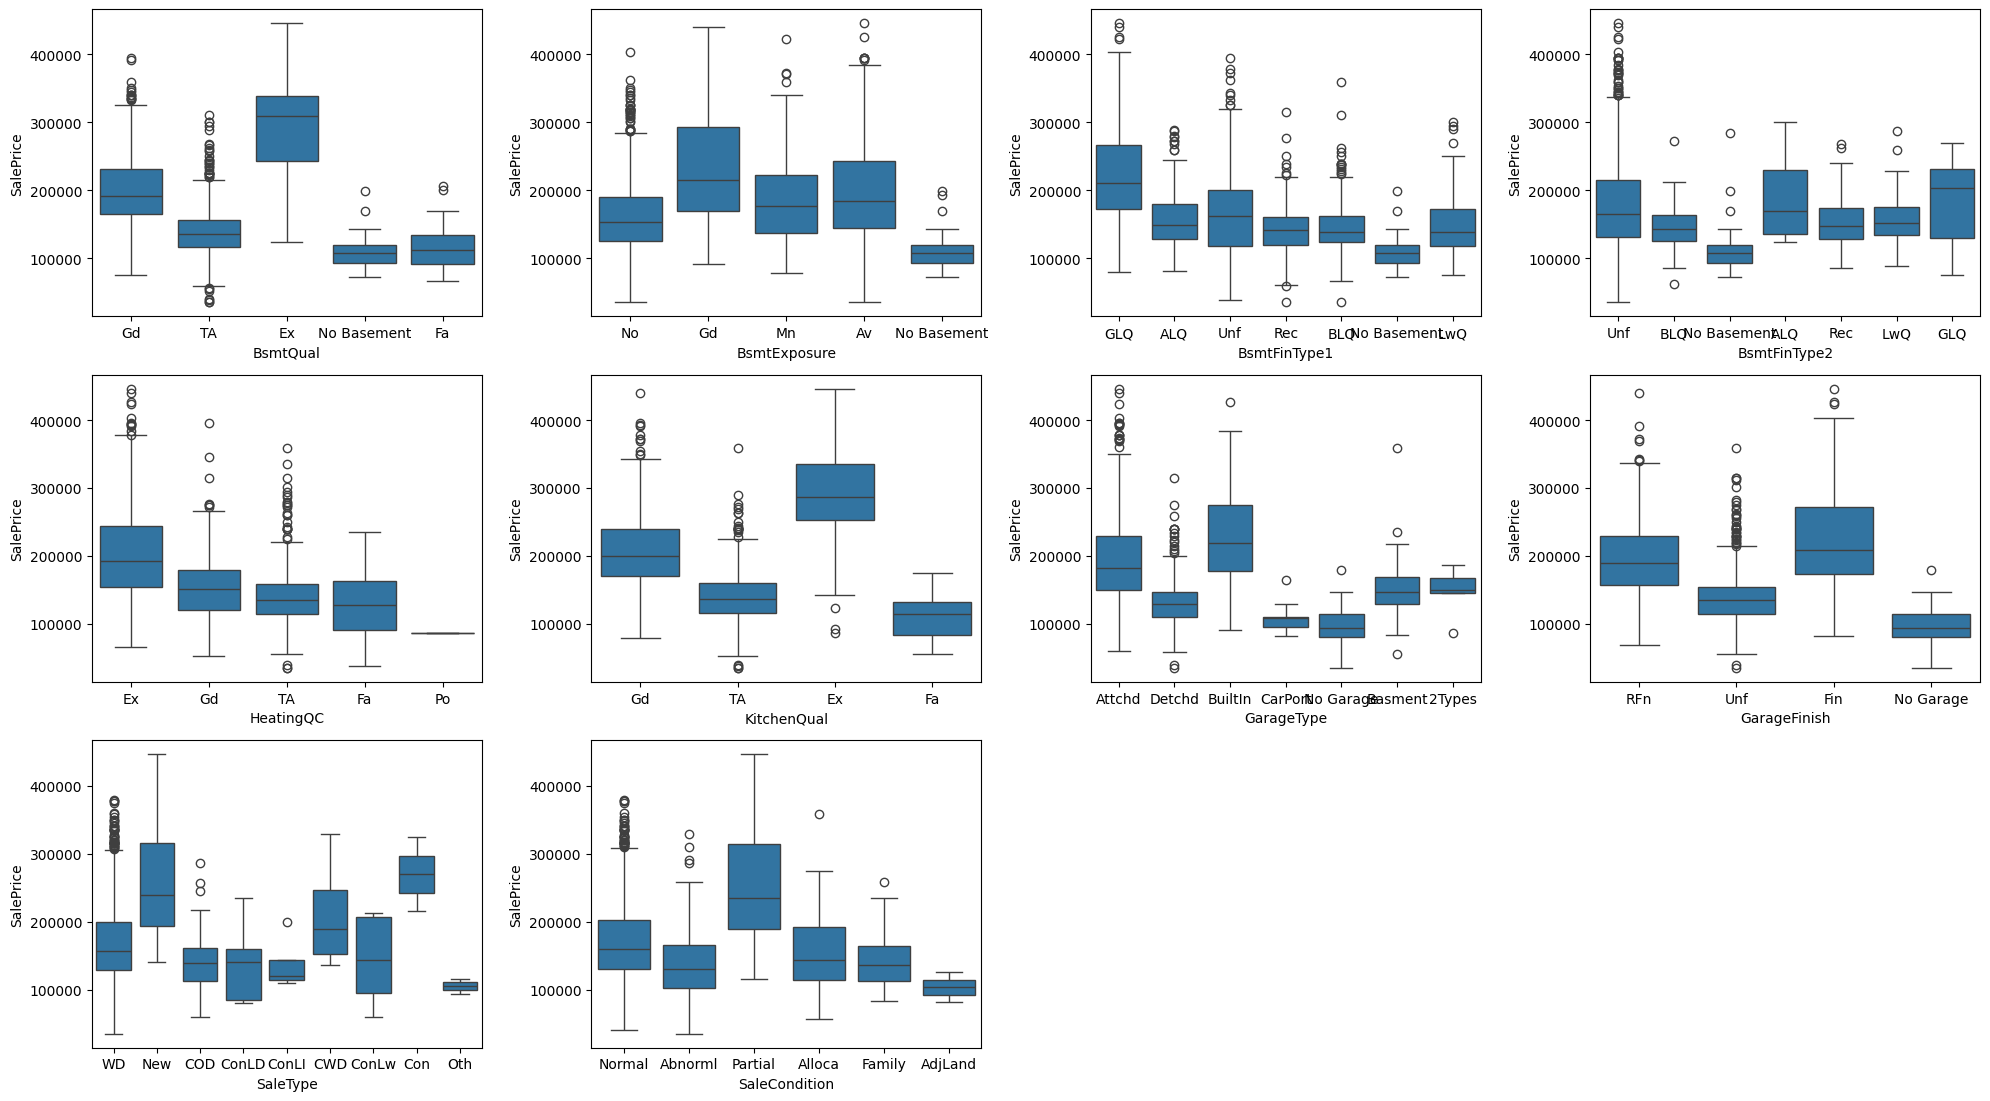

In [22]:
# Select categorical features
categorical_columns = train_df.select_dtypes(include=["object"]).columns

# Drop columns with too many categories
drop_columns = ["Neighborhood", "MSSubClass", "Exterior1st", "Exterior2nd"]

# Create boxplots for all categorical features against SalePrice

# Bigger plots for columns with many categories
plt.figure(figsize=(20, 18))
for index, feature in enumerate(train_df[drop_columns]):
    plt.subplot(len(drop_columns), 1, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

categorical_columns = categorical_columns.drop(drop_columns)
plt.figure(figsize=(20, 18))

for index, feature in enumerate(categorical_columns[:len(categorical_columns)//2]):
    plt.subplot(5, 4, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

plt.figure(figsize=(20, 18))

for index, feature in enumerate(categorical_columns[len(categorical_columns)//2:]):
    plt.subplot(5, 4, index + 1)
    sns.boxplot(x = train_df[feature], y = train_df['SalePrice'])

plt.tight_layout()

plt.show()

## Regression

Use one-hot encoding to convert categorical variables into indicator variables

In [23]:
categorical_cols = train_df.select_dtypes(include=[object]).columns

train_df = pd.get_dummies(train_df, columns = categorical_cols, drop_first = True)

Split into training and test data

In [24]:
y = train_df["SalePrice"]
x = train_df.drop(columns=["SalePrice"])

# Split data into training and test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, train_size = 0.8)

Train a simple Linear Regression model and evaluate its performance

In [25]:
# Train
model = LinearRegression()
model.fit(x_train, y_train)

# Test
y_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Root Mean Squared Error: {rmse}')

avg_saleprice = y_test.mean()
print(f'Average SalePrice: {avg_saleprice}')

print(f'Percentage RMSE: {round(rmse / avg_saleprice * 100, 2)}%')

Root Mean Squared Error: 19198.930907905975
Average SalePrice: 177108.10071942446
Percentage RMSE: 10.84%
